In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score


%matplotlib inline
pio.renderers.default='iframe'

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [154]:
df = pd.read_pickle("../../data_lake/output/train.pkl")
val = pd.read_pickle("../../data_lake/output/val.pkl")

# 2.0 EDA

In [155]:
df = df.drop(columns=['dist2','customer_id','TransactionID','id_21', 'id_22', 'id_24', 'id_25',
       'id_26'])
val = val.drop(columns=['dist2','customer_id','TransactionID','id_21', 'id_22', 'id_24', 'id_25',
       'id_26'])

In [156]:
df.shape

(16054, 33)

In [158]:
df.sample(2)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M4,id_23,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,max_c,max_d,num_transactio_per_time,multi_transaction_per_time
94525,1,125.0,R,15063,514.0,150.0,visa,226.0,credit,184.0,87.0,gmail.com,gmail.com,NaN,IP_PROXY:TRANSPARENT,Found,Found,Found,Android 7.1.1,other,32.0,855x480,match_status:2,T,F,T,F,mobile,Z835 Build/NMF26V,2.0,0.000000,1,0
122563,1,200.0,R,13844,583.0,150.0,visa,226.0,credit,204.0,87.0,anonymous.com,gmail.com,NaN,NaN,NaN,Found,Found,NaN,firefox 57.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows,2.0,0.041666,1,0


In [159]:
df['isFraud'].value_counts()

1    8027
0    8027
Name: isFraud, dtype: int64

In [178]:
fr = df[df['isFraud']=='1']

In [182]:
fr.describe(include='object')

,isFraud,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M4,id_23,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027
unique,1,4,1050,216,53,5,45,3,77,17,33,31,4,4,2,3,3,60,96,5,58,4,3,3,3,3,3,399
top,1,C,9633,545.0,185.0,visa,226.0,credit,nan,nan,gmail.com,gmail.com,M2,nan,nan,Found,Found,nan,chrome 63.0,nan,nan,nan,F,F,T,F,mobile,Windows
freq,8027,5402,503,935,4974,4949,2377,4770,5254,5254,4439,4698,4437,7727,7727,5540,5537,5572,1062,5568,5637,5541,5476,7774,6537,5123,3998,2184


In [183]:
df[df['isFraud']=='0'].describe(include='object')

,isFraud,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M4,id_23,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027,8027
unique,1,4,1969,322,55,5,56,3,105,23,58,57,4,4,2,3,3,72,97,4,94,4,3,3,3,3,3,608
top,0,C,15885,545.0,150.0,visa,226.0,credit,nan,87.0,gmail.com,gmail.com,nan,nan,nan,Found,Found,nan,chrome 63.0,nan,nan,match_status:2,T,F,T,F,desktop,Windows
freq,8027,3269,561,834,4827,4931,3036,4105,3166,4685,2861,2934,4844,7741,7741,4125,4049,3534,1288,3533,3785,3561,4508,7462,6167,4064,4818,2736


In [160]:
# for i in df:
#     if 'id' in i:
#         print(df[i].value_counts(dropna=False,normalize=True))

In [161]:
# df.isna().sum()

In [162]:
# df.nunique()

In [163]:
# for i in df:
#     if df[i].dtypes == 'object':
#         if i != 'TransactionID':
#             print(df[i].value_counts(dropna=False))

In [164]:
# for i in df:
#     if df[i].dtypes != 'object':
#         plt.figure(i)
#         plt.title(i)
#         df[i].hist()

In [165]:
def model_training(X_train, y_train, numerical_cols, categorical_cols,parameters):
    """
    
    """
    
    ##
    numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", MinMaxScaler())])
    categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                           ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                               ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
    pipe_model = GradientBoostingClassifier(random_state=0)
    ##
    model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])
    ##
    model.fit(X_train,y_train)
    model_grid = GridSearchCV(model,parameters,cv=2,scoring='precision',verbose=0,return_train_score=True).fit(X_train,y_train)
    print('GridSearchCV results...')
    print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
    print("Mean CV Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))
    print("Best Parameters: \n{}\n".format(model_grid.best_params_))
    
    return model_grid

In [166]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [167]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [168]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [169]:
parameters = {'model__max_depth':[2,4],'model__n_estimators':[250,500],'model__learning_rate':[0.5,0.05]}

In [170]:
model = model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.896066   0.9251991  0.95896866 0.97908759 0.81948457 0.83983407
 0.8639323  0.88040483]

Mean CV Scores: 
[0.83338828 0.83939731 0.85044868 0.85201324 0.81270695 0.82375347
 0.83228352 0.83992052]

Best Parameters: 
{'model__learning_rate': 0.5, 'model__max_depth': 4, 'model__n_estimators': 500}



In [171]:
def model_evaluation(model,X_test,y_test):
    """
    
    """
    print('Test results...')
    y_test_predict_grid = model.predict(X_test)    
    print("Model Test Accuracy:", metrics.precision_score(y_test, y_test_predict_grid))
    print('--------------------------------------------------')
    print('Model Test Confusion Matrix')
    cm = confusion_matrix(y_test,y_test_predict_grid,normalize='pred') 
    cmd = ConfusionMatrixDisplay(cm,display_labels=['No','Yes'])
    cmd.plot()
    
    ##
    feature_importances = model.best_estimator_.named_steps['model'].feature_importances_
    feature_names = X_test.columns
    lista = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    #         print('{}: {}'.format(name, score))
            lista.append(name)
    print('First ten features by importances:')
    print(lista[0:10])
    
    return model

In [172]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [173]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

Test results...
Model Test Accuracy: 0.3515491583313003
--------------------------------------------------
Model Test Confusion Matrix
First ten features by importances:
['ProductCD', 'TransactionAmt', 'card1', 'card6', 'addr1', 'card5', 'addr2', 'card2', 'id_23', 'card4']


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_preprocessor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                                         random_state=1),
                                                                                                           random_state=1)),
                                                                                         ('scaler',
                                                                  

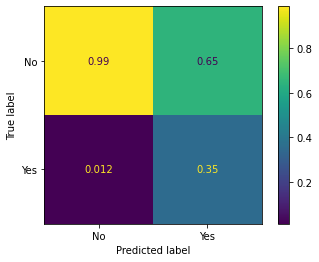

In [174]:
model_evaluation(model,X_val,y_val)

In [93]:
from sklearn.metrics import precision_recall_curve

In [75]:
y_score = model.predict_proba(X_val)[:, 1]

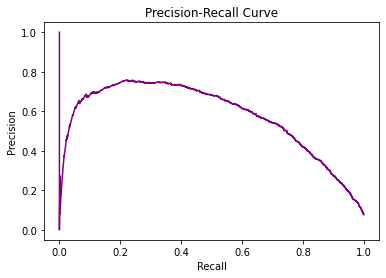

In [77]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [78]:
thresholds

array([4.66471297e-04, 5.31623076e-04, 5.58418361e-04, ...,
       9.99999945e-01, 9.99999961e-01, 9.99999986e-01])

In [79]:
f1_scores = 2 * recall * precision / (recall + precision)
best_f1 = np.max(f1_scores)
best_thresh = thresholds[np.argmax(f1_scores)]
best_predictions = (y_score > best_thresh)

/tmp/ipykernel_775/3063018414.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [80]:
best_thresh

0.9999977906249952

In [81]:
best_f1

nan